Sleep Prediction With Decision Tree Regresor

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV # Ditambahkan GridSearchCV

from fairlearn.metrics import MetricFrame

In [75]:
# --- 2. Persiapan dan Pembersihan Data (Data Preprocessing) ---

print("--- Memuat Data ---")
# Asumsi file Sleep_Quality_Dataset.txt berada di direktori yang sama
# Menggunakan separator koma (',') karena ini adalah CSV
df = pd.read_csv('Sleep_Quality_Dataset.csv')
print("Data berhasil dimuat.")
print("Bentuk DataFrame:", df.shape)
print("\nInfo DataFrame:")
df.info()
print("\nLima baris pertama data:")
print(df.head())

--- Memuat Data ---
Data berhasil dimuat.
Bentuk DataFrame: (500, 12)

Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   User ID                  500 non-null    int64 
 1   Age                      500 non-null    int64 
 2   Gender                   500 non-null    object
 3   Sleep Quality            500 non-null    int64 
 4   Bedtime                  500 non-null    object
 5   Wake-up Time             500 non-null    object
 6   Daily Steps              500 non-null    int64 
 7   Calories Burned          500 non-null    int64 
 8   Physical Activity Level  500 non-null    object
 9   Dietary Habits           500 non-null    object
 10  Sleep Disorders          500 non-null    object
 11  Medication Usage         500 non-null    object
dtypes: int64(5), object(7)
memory usage: 47.0+ KB

Lima baris per

In [76]:
# Menghapus kolom 'User ID' karena tidak relevan untuk prediksi
df = df.drop('User ID', axis=1)
print("\nKolom 'User ID' telah dihapus.")


Kolom 'User ID' telah dihapus.


In [77]:
# Mengubah 'Gender' menjadi numerik (0 dan 1)
df['Gender'] = df['Gender'].map({'m': 0, 'f': 1})
print("\nKolom 'Gender' telah diubah menjadi numerik (m=0, f=1).")


Kolom 'Gender' telah diubah menjadi numerik (m=0, f=1).


In [78]:
# Mengubah 'Bedtime' dan 'Wake-up Time' menjadi durasi tidur dalam jam
# Fungsi untuk menghitung durasi tidur
def calculate_sleep_duration(bedtime_str, wake_up_str):
    # Mengubah string waktu menjadi objek datetime
    # Asumsi format HH:MM
    bedtime = pd.to_datetime(bedtime_str, format='%H:%M')
    wake_up_time = pd.to_datetime(wake_up_str, format='%H:%M')

    # Jika wake_up_time lebih awal dari bedtime, berarti tidur melewati tengah malam
    if wake_up_time < bedtime:
        wake_up_time += pd.Timedelta(days=1)

    duration = (wake_up_time - bedtime).total_seconds() / 3600 # dalam jam
    return duration

df['Sleep Duration'] = df.apply(lambda row: calculate_sleep_duration(row['Bedtime'], row['Wake-up Time']), axis=1)

# Menghapus kolom 'Bedtime' dan 'Wake-up Time' asli
df = df.drop(['Bedtime', 'Wake-up Time'], axis=1)
print("\nKolom 'Bedtime' dan 'Wake-up Time' telah diubah menjadi 'Sleep Duration'.")



Kolom 'Bedtime' dan 'Wake-up Time' telah diubah menjadi 'Sleep Duration'.


In [79]:
# Menangani missing values yang mungkin muncul dari konversi waktu yang gagal (jika ada)
# Dalam kasus ini, kita asumsikan tidak ada kegagalan format, tapi ini praktik yang baik
if df['Sleep Duration'].isnull().any():
    print(f"Ditemukan {df['Sleep Duration'].isnull().sum()} missing values di 'Sleep Duration'. Akan dihapus.")
    df.dropna(subset=['Sleep Duration'], inplace=True)


In [80]:
# Encoding untuk kolom kategorikal lainnya
# 'Physical Activity Level', 'Dietary Habits', 'Sleep Disorders', 'Medication Usage'
categorical_cols = ['Physical Activity Level', 'Dietary Habits', 'Sleep Disorders', 'Medication Usage']

In [81]:
# Memisahkan fitur (X_eda) dan target (y_eda) untuk EDA dan kemudian untuk encoding
# Kita buat salinan df_eda agar tidak mengganggu df asli untuk proses encoding berikutnya
df_eda = df.copy() # Salinan untuk EDA

# --- 2.5 Exploratory Data Analysis (EDA) ---
print("\n--- Memulai Exploratory Data Analysis (EDA) ---")

# Ringkasan Statistik untuk fitur numerik
print("\nRingkasan Statistik Fitur Numerik:")
print(df_eda.describe())


--- Memulai Exploratory Data Analysis (EDA) ---

Ringkasan Statistik Fitur Numerik:
              Age      Gender  Sleep Quality   Daily Steps  Calories Burned  \
count  500.000000  500.000000     500.000000    500.000000       500.000000   
mean    38.314000    0.500000       6.010000   6856.700000      2416.730000   
std     13.364454    0.500501       1.976287   2526.810777       414.659144   
min     18.000000    0.000000       1.000000   2018.000000      1541.000000   
25%     28.000000    0.000000       5.000000   4471.750000      2119.500000   
50%     34.500000    0.500000       6.000000   7147.000000      2408.500000   
75%     48.000000    1.000000       8.000000   9067.250000      2695.250000   
max     69.000000    1.000000      10.000000  11904.000000      3394.000000   

       Sleep Duration  
count      500.000000  
mean         6.992500  
std          1.159529  
min          4.500000  
25%          6.437500  
50%          7.000000  
75%          8.000000  
max        

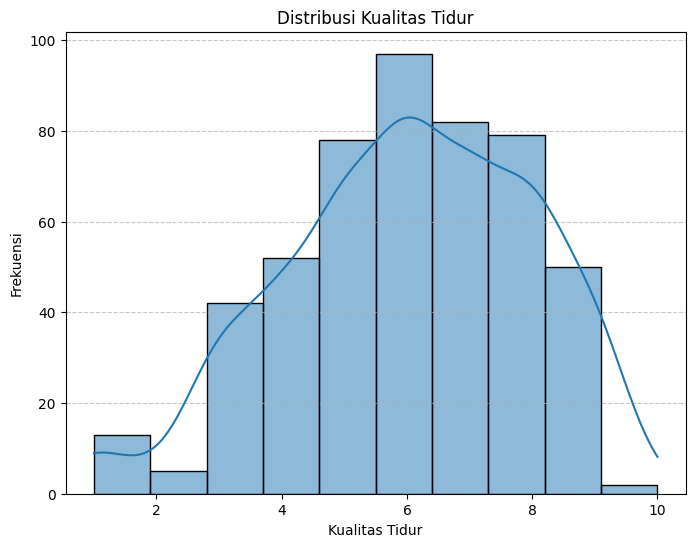

In [82]:
# Visualisasi Distribusi Kualitas Tidur
plt.figure(figsize=(8, 6))
sns.histplot(df_eda['Sleep Quality'], bins=10, kde=True)
plt.title('Distribusi Kualitas Tidur')
plt.xlabel('Kualitas Tidur')
plt.ylabel('Frekuensi')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

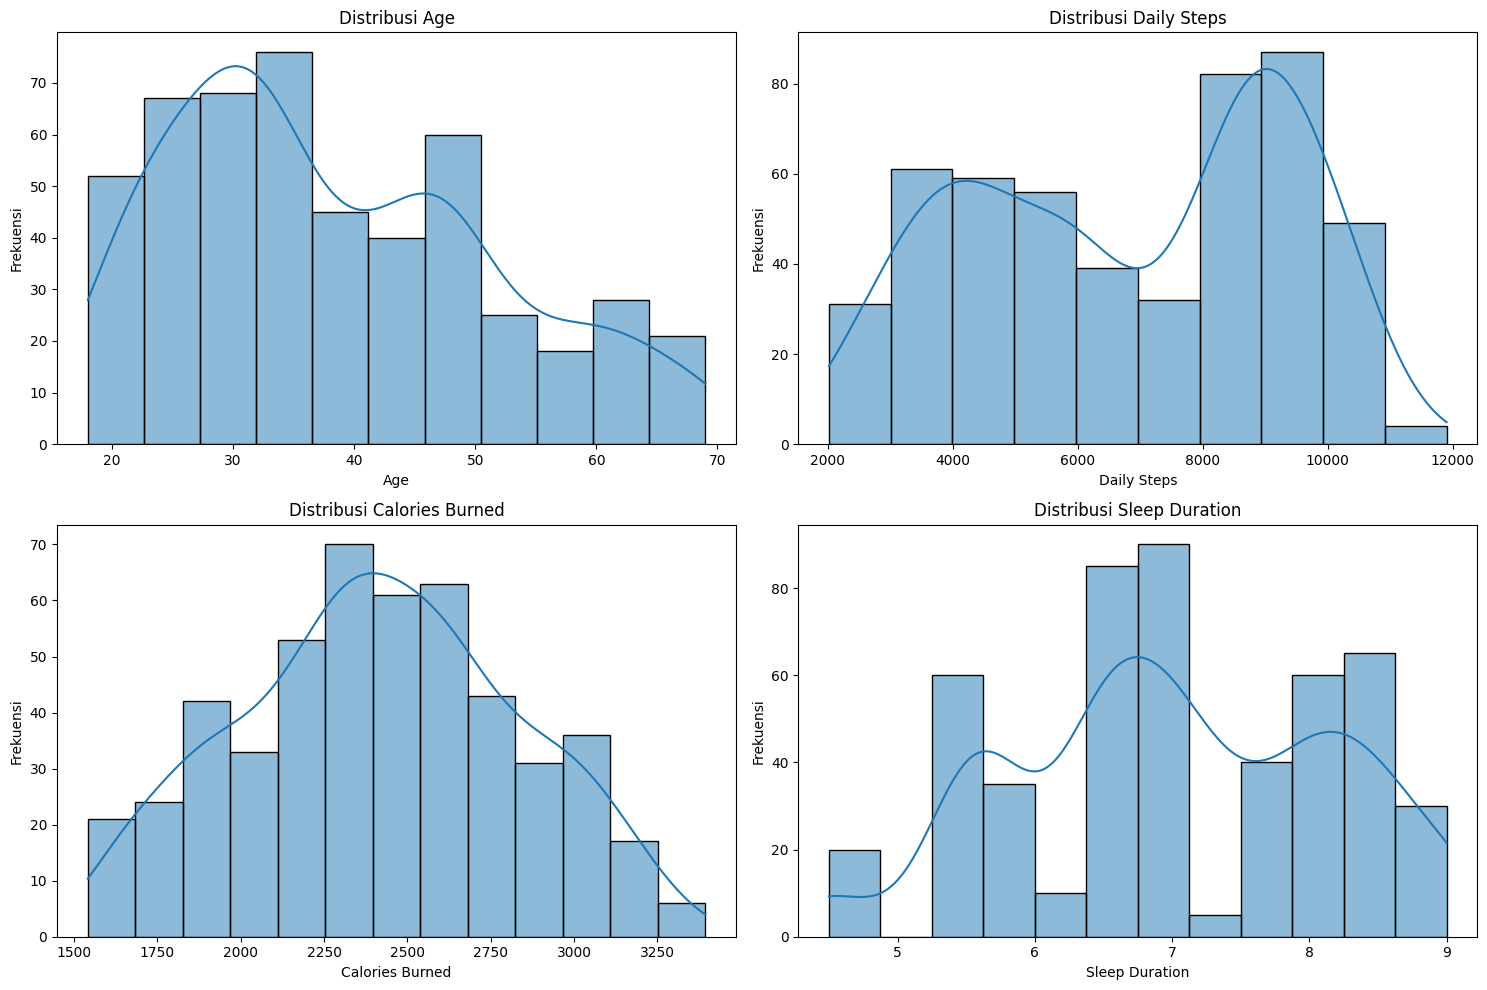

In [83]:
# Visualisasi Distribusi Fitur Numerik lainnya
numerical_cols_for_eda = ['Age', 'Daily Steps', 'Calories Burned', 'Sleep Duration']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols_for_eda):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_eda[col], kde=True)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
plt.tight_layout()
plt.show()

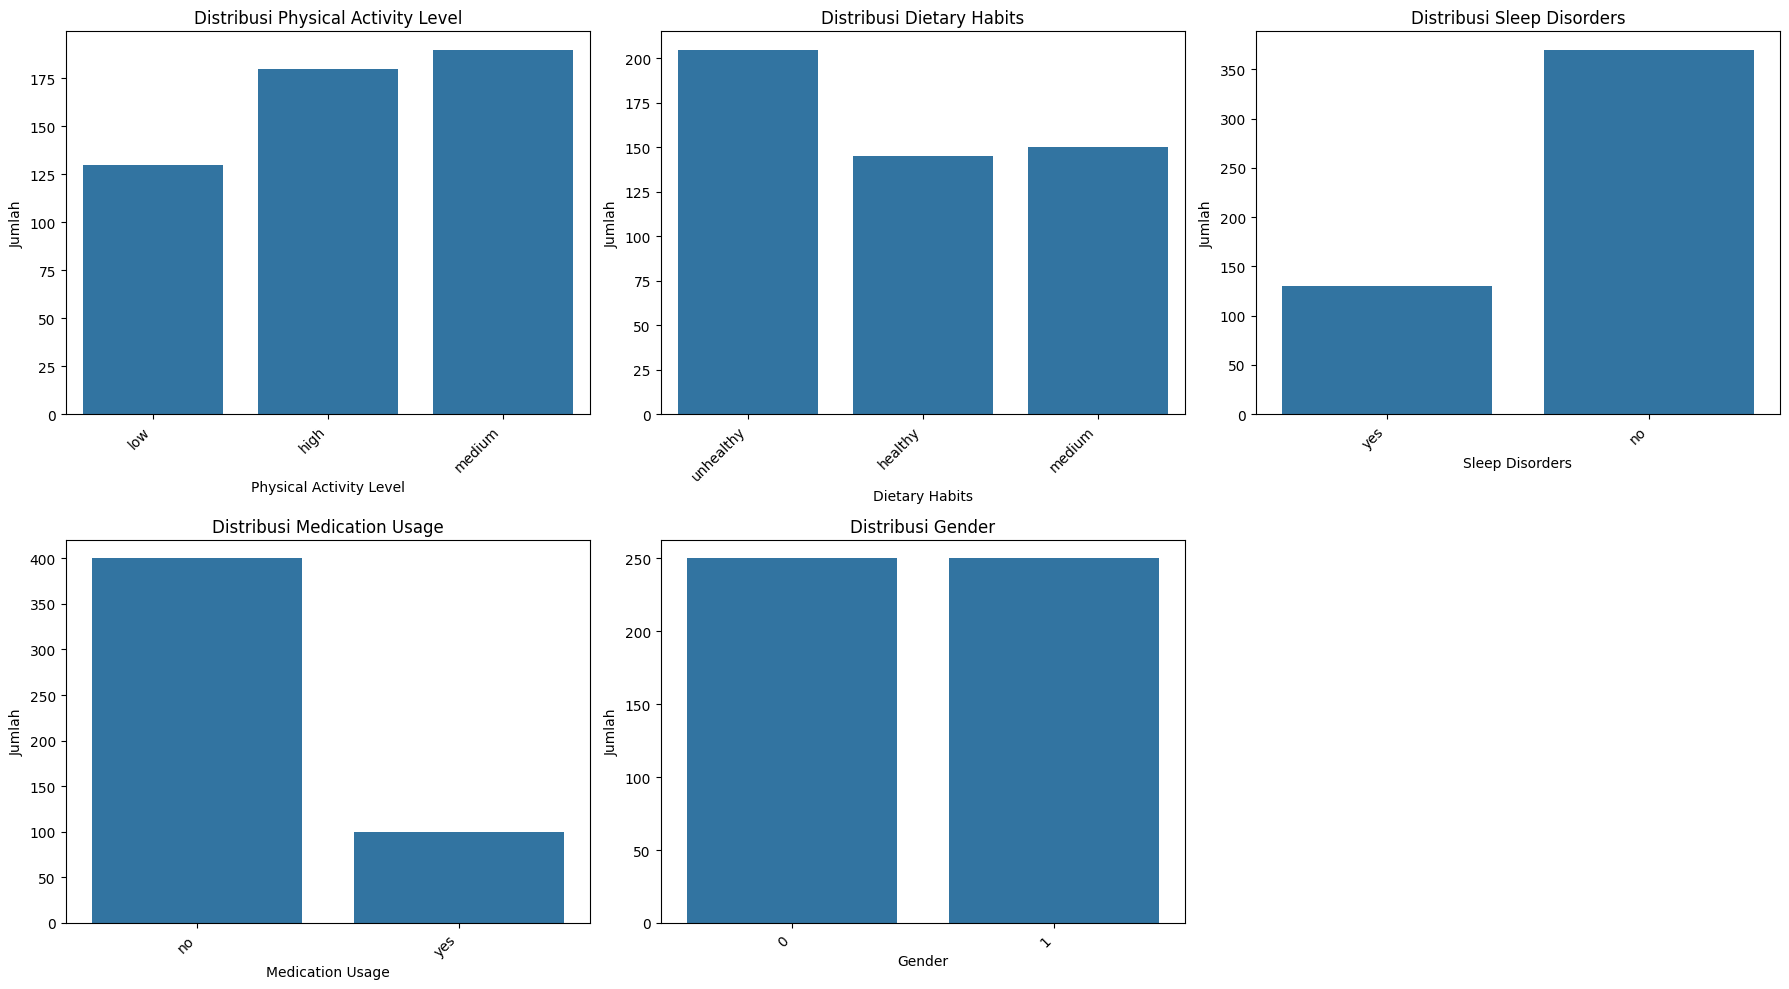

In [84]:
# Visualisasi Distribusi Fitur Kategorikal
plt.figure(figsize=(18, 10))
for i, col in enumerate(categorical_cols + ['Gender']): # Tambahkan Gender karena sudah numerik
    plt.subplot(2, 3, i + 1)
    sns.countplot(data=df_eda, x=col)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Jumlah')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

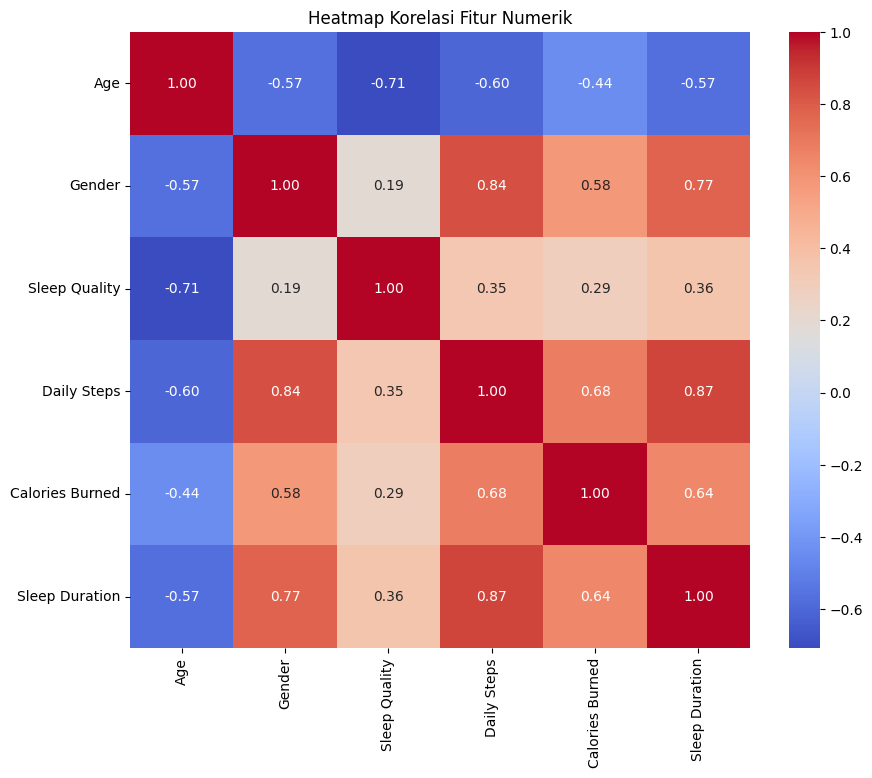

In [85]:
# Korelasi antar Fitur Numerik
# Pastikan semua kolom numerik ada di df_eda
df_numeric = df_eda.select_dtypes(include=np.number)
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

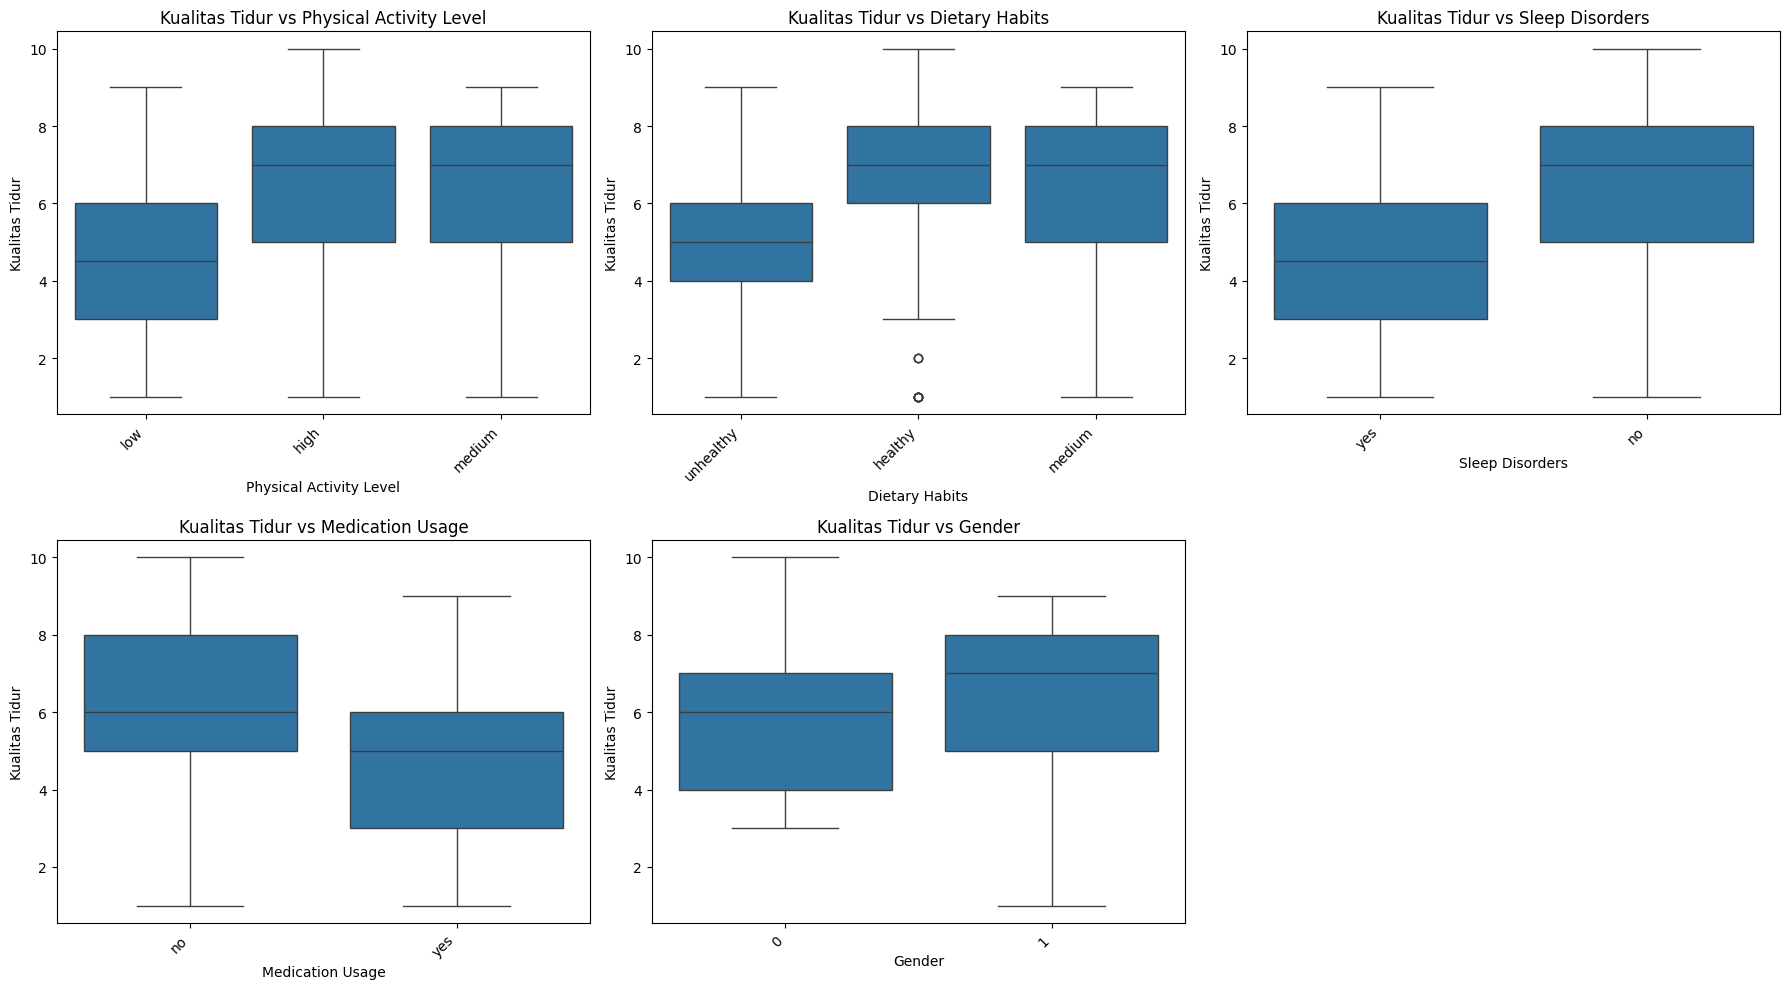

In [86]:
# Hubungan Kualitas Tidur dengan Fitur Kategorikal (Box Plot)
plt.figure(figsize=(18, 10))
for i, col in enumerate(categorical_cols + ['Gender']):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df_eda, x=col, y='Sleep Quality')
    plt.title(f'Kualitas Tidur vs {col}')
    plt.xlabel(col)
    plt.ylabel('Kualitas Tidur')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [87]:
# Memisahkan fitur (X) dan target (y) sebelum encoding untuk menghindari target ter-encode
X = df.drop('Sleep Quality', axis=1)
y = df['Sleep Quality']

# Menggunakan OneHotEncoder untuk kolom kategorikal
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough' # Biarkan kolom lain apa adanya
)
X_encoded = ct.fit_transform(X)

In [88]:
# Mendapatkan nama fitur setelah one-hot encoding
feature_names = ct.get_feature_names_out(X.columns)
X_processed = pd.DataFrame(X_encoded, columns=feature_names)

print("\nKolom kategorikal telah di-encode (One-Hot Encoding).")
print("\nLima baris pertama data setelah preprocessing:")
print(X_processed.head())
print("\nInfo DataFrame setelah preprocessing:")
X_processed.info()


Kolom kategorikal telah di-encode (One-Hot Encoding).

Lima baris pertama data setelah preprocessing:
   encoder__Physical Activity Level_high  \
0                                    0.0   
1                                    0.0   
2                                    1.0   
3                                    0.0   
4                                    1.0   

   encoder__Physical Activity Level_low  \
0                                   1.0   
1                                   1.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   

   encoder__Physical Activity Level_medium  encoder__Dietary Habits_healthy  \
0                                      0.0                              0.0   
1                                      0.0                              0.0   
2                                      0.0                              1.0   
3                                      1.0               

In [89]:
# Pembagian Data: Training (70%), Validation (15%), Testing (15%)
# Pertama, bagi menjadi training dan temporary (gabungan validation+test)
X_train, X_temp, y_train, y_temp = train_test_split(X_processed, y, test_size=0.3, random_state=42)

# Kemudian, bagi temporary menjadi validation dan test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\nData berhasil dibagi:")
print(f"Ukuran Data Latih (Training): {X_train.shape[0]} baris")
print(f"Ukuran Data Validasi (Validation): {X_val.shape[0]} baris")
print(f"Ukuran Data Uji (Testing): {X_test.shape[0]} baris")


Data berhasil dibagi:
Ukuran Data Latih (Training): 350 baris
Ukuran Data Validasi (Validation): 75 baris
Ukuran Data Uji (Testing): 75 baris


In [90]:
# --- 3. Pemilihan Model (Inisialisasi Awal) ---
print("\n--- Pemilihan Model (DecisionTreeRegressor) ---")
# Model diinisialisasi untuk GridSearchCV
model = DecisionTreeRegressor(random_state=42)
print("Model yang dipilih: DecisionTreeRegressor.")
print(f"Parameter default (random_state=42)")



--- Pemilihan Model (DecisionTreeRegressor) ---
Model yang dipilih: DecisionTreeRegressor.
Parameter default (random_state=42)


In [91]:
# --- 4.5 Penyetelan Model (Hyperparameter Tuning) ---
print("\n--- Memulai Penyetelan Model (Hyperparameter Tuning) untuk DecisionTreeRegressor ---")

# Definisikan grid hyperparameter yang ingin dicoba
param_grid = {
    'max_depth': [None, 5, 10, 15, 20], # Coba kedalaman maksimum berbeda
    'min_samples_split': [2, 5, 10, 20], # Jumlah minimum sampel untuk memecah simpul
    'min_samples_leaf': [1, 2, 4, 8] # Jumlah minimum sampel di simpul daun
}

# Inisialisasi GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5, # Gunakan cross-validation pada data training
    scoring='neg_mean_squared_error', # Maksimalkan NEGATIF MSE (berarti minimalkan MSE)
    n_jobs=-1, # Gunakan semua core CPU
    verbose=1 # Tampilkan progress
)

# Latih GridSearchCV pada data Latih
grid_search.fit(X_train, y_train)

# Dapatkan hyperparameter terbaik
best_params = grid_search.best_params_
print(f"\nHyperparameter terbaik ditemukan: {best_params}")

# Dapatkan model terbaik dari hasil grid search
model = grid_search.best_estimator_
print("Model DecisionTreeRegressor terbaik telah ditemukan dan digunakan.")


--- Memulai Penyetelan Model (Hyperparameter Tuning) untuk DecisionTreeRegressor ---
Fitting 5 folds for each of 80 candidates, totalling 400 fits

Hyperparameter terbaik ditemukan: {'max_depth': 5, 'min_samples_leaf': 8, 'min_samples_split': 2}
Model DecisionTreeRegressor terbaik telah ditemukan dan digunakan.


In [92]:
# # --- 4. Melatih Model (Model Training) ---
# print("\n--- Melatih Model ---")
# model.fit(X_train, y_train)
# print("Model telah selesai dilatih menggunakan Data Latih.")

In [93]:
# --- 5. Evaluasi Model ---
print("\n--- Evaluasi Model ---")

# Prediksi pada Data Validasi
y_pred_val = model.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(f"Kinerja pada Data Validasi:")
print(f"  Mean Squared Error (MSE): {mse_val:.4f}")
print(f"  R2 Score: {r2_val:.4f}")



--- Evaluasi Model ---
Kinerja pada Data Validasi:
  Mean Squared Error (MSE): 0.8276
  R2 Score: 0.7613



--- Visualisasi Fitur Terpenting ---
Fitur Terpenting (Top 10):
                                    Feature  Importance
10                           remainder__Age    0.756722
11                        remainder__Gender    0.173195
12                   remainder__Daily Steps    0.040658
14                remainder__Sleep Duration    0.018820
13               remainder__Calories Burned    0.009626
2   encoder__Physical Activity Level_medium    0.000979
0     encoder__Physical Activity Level_high    0.000000
1      encoder__Physical Activity Level_low    0.000000
3           encoder__Dietary Habits_healthy    0.000000
4            encoder__Dietary Habits_medium    0.000000


C:\Users\USER.LAPTOP-I5FQJV1F\AppData\Local\Temp\ipykernel_736\749216257.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


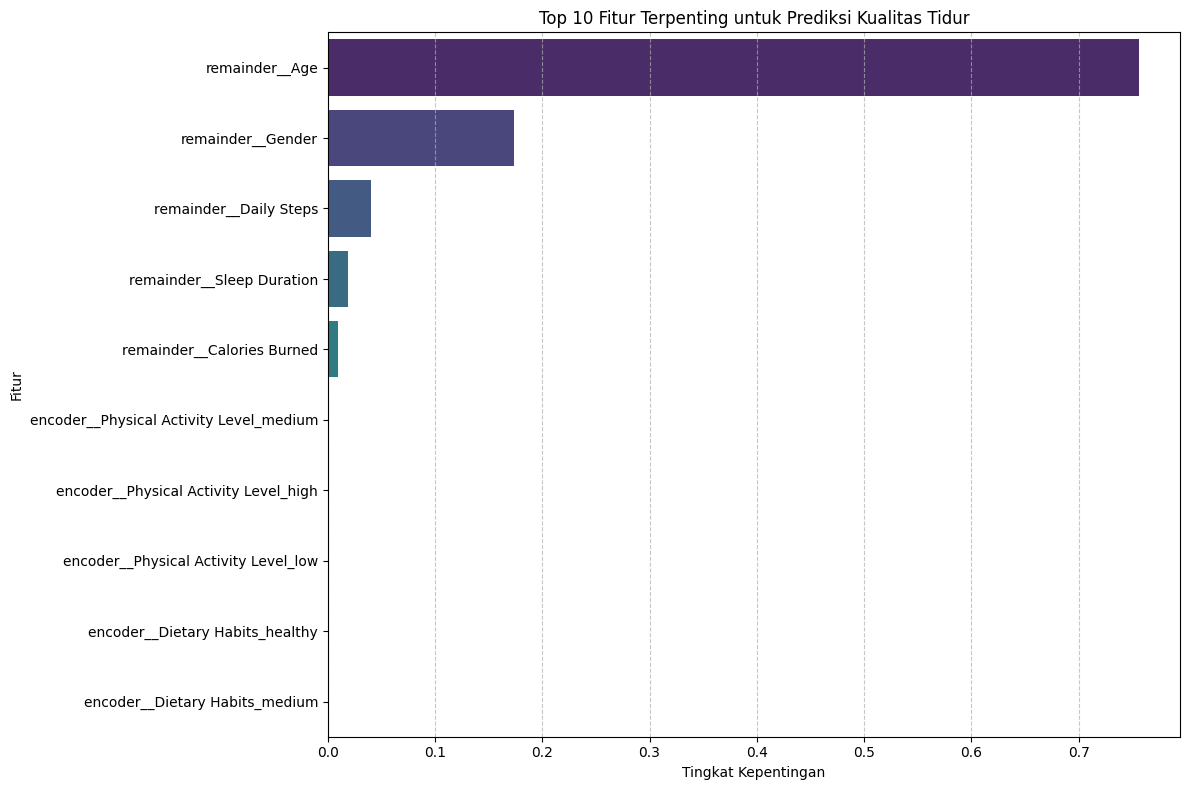

In [94]:
# --- 5.5 Visualisasi Fitur Terpenting ---
print("\n--- Visualisasi Fitur Terpenting ---")

# Mengambil feature importances dari model
importances = model.feature_importances_

# Mendapatkan nama fitur dari X_train (yang sudah di-encode)
# Pastikan urutan feature_names sesuai dengan urutan kolom di X_train
feature_names_list = X_train.columns

# Membuat Series dari feature importances dan nama fitur
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_list,
    'Importance': importances
})

# Mengurutkan fitur berdasarkan kepentingannya dari yang terbesar
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Menampilkan 10 fitur terpenting (atau semua jika kurang dari 10)
print("Fitur Terpenting (Top 10):")
print(feature_importance_df.head(10))

# Visualisasi
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Fitur Terpenting untuk Prediksi Kualitas Tidur')
plt.xlabel('Tingkat Kepentingan')
plt.ylabel('Fitur')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [95]:
# Prediksi pada Data Uji (ini adalah evaluasi akhir)
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"\nKinerja pada Data Uji (Evaluasi Akhir):")
print(f"  Mean Squared Error (MSE): {mse_test:.4f}")
print(f"  R2 Score: {r2_test:.4f}")



Kinerja pada Data Uji (Evaluasi Akhir):
  Mean Squared Error (MSE): 1.3281
  R2 Score: 0.6778



--- Analisis Keadilan Model Berdasarkan Gender ---

Kinerja Model berdasarkan Gender (misalnya 0=Male, 1=Female):
             MSE  R2 Score
Gender                    
0       1.360739  0.623823
1       1.297877  0.687053


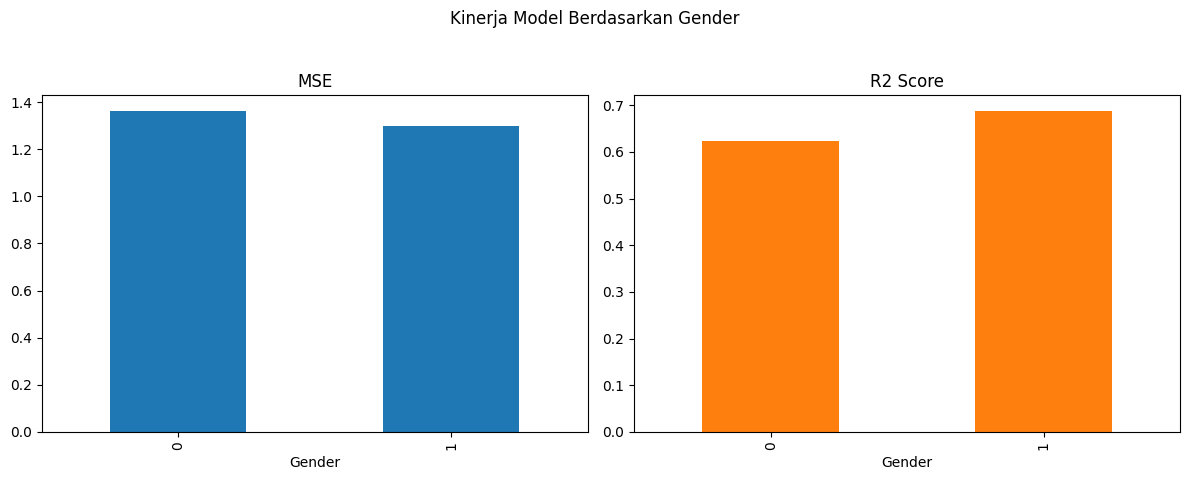


--- Analisis Keadilan Model Selesai ---


In [96]:
print("\n--- Analisis Keadilan Model Berdasarkan Gender ---")

# Ambil atribut sensitif (Gender) sesuai index dari X_test
sensitive_attribute_test = df.loc[X_test.index, 'Gender']

# Gunakan MetricFrame untuk mengukur performa berdasarkan Gender
grouped_on_gender_metrics = MetricFrame(
    metrics={
        'MSE': mean_squared_error,
        'R2 Score': r2_score
    },
    y_true=y_test,
    y_pred=y_pred_test,
    sensitive_features=sensitive_attribute_test
)

print("\nKinerja Model berdasarkan Gender (misalnya 0=Male, 1=Female):")
print(grouped_on_gender_metrics.by_group)

# Visualisasi metrik
grouped_on_gender_metrics.by_group.plot.bar(
    subplots=True, layout=(1, 2), figsize=(12, 5), legend=False
)
plt.suptitle('Kinerja Model Berdasarkan Gender')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Tampilkan selisih keadilan
# print(f"\nPerbedaan MSE Terbesar antar Gender: {grouped_on_gender_metrics.difference(metric='MSE'):.4f}")
# print(f"Perbedaan R2 Score Terbesar antar Gender: {grouped_on_gender_metrics.difference(metric='R2 Score'):.4f}")

print("\n--- Analisis Keadilan Model Selesai ---")